<a href="https://colab.research.google.com/github/thiagolimaop/chest-x-ray-classifier/blob/main/ChestXRay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação de imagens de Raio-X de Torax (Pneumonia x Normal)

Este projeto tem como objetivo treinar um conjunto de imagens de Raio-X do torax para classificar pulmões com Pneumonia ou não. O dataset foi encontrado no Kaggle e foi disponibilizado pela [Mendeley Data](https://data.mendeley.com/datasets/rscbjbr9sj/2).

Vamos começar por atualizar a biblioteca do tersorflow.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import glob
from google.colab.patches import cv2_imshow

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

!pip install gdown
import gdown
import os
import zipfile
import logging
import shutil
import random

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## 1. Carga dos dados

Primeiro começamos por baixar os dados do dataset para a nossa base.

In [2]:
file_id = "1St8lp-ZZUDk4vbi9ISEY3GvTS0AhHkAU"
url = f"https://drive.google.com/uc?id={file_id}"

folder_path = "./dataset"  # especifique a pasta onde baixara o arquivo
os.makedirs(folder_path, exist_ok=True) # cria a pasta de destino se necessário

output = "dataset/ChestXRay2017.zip"  # especifique o nome do arquivo e a extensão do mesmo
gdown.download(url, output)

Downloading...
From: https://drive.google.com/uc?id=1St8lp-ZZUDk4vbi9ISEY3GvTS0AhHkAU
To: /content/dataset/ChestXRay2017.zip
100%|██████████| 1.24G/1.24G [00:11<00:00, 106MB/s] 


'dataset/ChestXRay2017.zip'

Os dados estão comprimidos e por isso será necessário descomprimi-los para podermos analizar as imagens e criar o modelo.

In [3]:
destination = 'dataset' # path onde se encontra o arquivo 'train.zip'

os.makedirs(destination,exist_ok=True) # cria a pasta de destino se necessário

with zipfile.ZipFile(output,'r') as zip_ref:
    zip_ref.extractall(destination)

Vamos listar os diretórios para compreender melhor nossos dados.

In [4]:
dir = 'dataset/chest_xray'
zip_dir_base = os.path.dirname(dir)
!find $zip_dir_base -type d -print

dataset
dataset/chest_xray
dataset/chest_xray/test
dataset/chest_xray/test/PNEUMONIA
dataset/chest_xray/test/NORMAL
dataset/chest_xray/train
dataset/chest_xray/train/PNEUMONIA
dataset/chest_xray/train/NORMAL
dataset/__MACOSX
dataset/__MACOSX/chest_xray
dataset/__MACOSX/chest_xray/test
dataset/__MACOSX/chest_xray/test/PNEUMONIA
dataset/__MACOSX/chest_xray/train
dataset/__MACOSX/chest_xray/train/PNEUMONIA
dataset/__MACOSX/chest_xray/train/NORMAL


Acima vemos que temos apenas uma pasta de treino e outra de teste. Porém é importante que tenhamos também um conjunto separado para validação do modelo durante o treinamento, uma vez que queremos evitar overfitting e ajustar os hiperparâmetros do modelo. Então iremos criar esta pasta e preenche-la com imagens aleatórias.

In [5]:
path = os.path.join(dir, 'val')
os.mkdir(path)

In [6]:
path_normal = os.path.join(dir, 'val/NORMAL')
os.mkdir(path_normal)

In [7]:
path_pneumonia = os.path.join(dir, 'val/PNEUMONIA')
os.mkdir(path_pneumonia)

Abaixo, é facilitado o acesso aos diretórios de treino e teste para tornar o código mais legível.

In [8]:
base_dir = os.path.join(os.path.dirname(dir), 'chest_xray')
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

## 2. Análise exploratória

Vamos entender como os dados das imagens estão divididos em treino e teste.

In [9]:
def get_total_chest_xray(category, source):
  """
  INPUT
  category: data set category, which could be 'training', 'test' and 'validation'
  source: a directory path.

  OUTPUT
  num_normal: total number of pictures
  num_pneumonia:
  total:

  DESCRIPTION
  This function move X (amount) random pictures from a source folder
  to destination folder.
  """
  source_normal = os.path.join(source, 'NORMAL')
  source_pneumonia = os.path.join(source, 'PNEUMONIA')

  num_normal = len(os.listdir(source_normal))
  num_pneumonia = len(os.listdir(source_pneumonia))
  total = num_normal + num_pneumonia

  print('Total {}: {}'.format(category, total))
  print('total {} normal images: {}'.format(category, num_normal))
  print('total {} pneumonia images: {}'.format(category, num_pneumonia))

  return num_normal, num_pneumonia, total

In [10]:
num_normal_tr, num_pneumonia_tr, total_train = get_total_chest_xray('training', train_dir)

Total training: 5233
total training normal images: 1349
total training pneumonia images: 3884


In [11]:
num_normal_test, num_pneumonia_test, total_test = get_total_chest_xray('test', test_dir)

Total test: 624
total test normal images: 234
total test pneumonia images: 390


É possível ver que as classes estão desbalanceadas, principalmente nos dados de treino onde temos quase 3 classes de pneumonia para 1 normal. Logo, é interessante usarmos a métrica do F1-Score para validar o treinamento do modelo.

Vamos confirmar se temos ao menos 20% da base de separada para o teste, o que é considerada uma amostra representativa.

In [12]:
total = total_train + total_test
twenty_perc = int(total*0.2)

print('Total de imagens: ', total)
print('20% do total de imagens: ', twenty_perc)

Total de imagens:  5857
20% do total de imagens:  1171


Acima vemos que a quantidade de imagens para teste ainda é insuficiente. Considerando as proporções de imagens de pneumonia e normal, quantas imagens deveria ser transferidas para a pasta de teste? E para a pasta de validação?

In [13]:
pneumonia_perc_train = num_pneumonia_tr/total_train
num_pneumonia_val = int(twenty_perc*pneumonia_perc_train)
num_normal_val = twenty_perc-num_pneumonia_val
num_pneumonia_test_needed = num_pneumonia_val - num_pneumonia_test
num_normal_test_needed = num_normal_val - num_normal_test

print('% de imagens de pneumonia para treinamento: ', pneumonia_perc_train)
print('Quantidade de imagens da classe pneumonia necessárias na base de validação: ', num_pneumonia_val)
print('Quantidade de imagens da classe normal necessárias na base de validação: ', num_normal_val)
print('Quantidade de imagens da classe pneumonia necessárias na base de teste: ', num_pneumonia_test_needed)
print('Quantidade de imagens da classe normal necessárias na base de teste: ', num_normal_test_needed)

% de imagens de pneumonia para treinamento:  0.7422128798012613
Quantidade de imagens da classe pneumonia necessárias na base de validação:  869
Quantidade de imagens da classe normal necessárias na base de validação:  302
Quantidade de imagens da classe pneumonia necessárias na base de teste:  479
Quantidade de imagens da classe normal necessárias na base de teste:  68


Abaixo temos uma função para transferir imagens aleatórias do diretório de treino para o diretório de teste.

In [14]:
def move_files(source_path, dest_path, amount):
  """
  INPUT:
  source_path: a string with the source path
  dest_path: a string with a destination path
  amount: the amount of pictures with need to be moved

  DESCRIPTION:
  This function move X (amount) random pictures from a source folder
  to destination folder.
  """
  seed = 7
  random.seed(seed)

  for i in range(amount):
    files = os.listdir(source_path)
    total_files = len(files)
    index = int(random.random()*total_files)

    source_file = os.path.join(source_path, files[index])
    dest_file = os.path.join(dest_path, files[index])
    shutil.move(source_file, dest_file)

Então executamos a transferência do diretório de treino para o diretório de validação.

In [15]:
train_normal_path = os.path.join(train_dir, 'NORMAL')
train_pneumonia_path = os.path.join(train_dir, 'PNEUMONIA')

move_files(train_normal_path, path_normal, num_normal_val)
move_files(train_pneumonia_path, path_pneumonia, num_pneumonia_val)

E fazemos o mesmo para preencher a parte faltante do diretório de teste.

In [16]:
test_normal_path = os.path.join(test_dir, 'NORMAL')
test_pneumonia_path = os.path.join(test_dir, 'PNEUMONIA')

move_files(train_normal_path, test_normal_path, num_normal_test_needed)
move_files(train_pneumonia_path, test_pneumonia_path, num_pneumonia_test_needed)

In [17]:
val_dir = os.path.join(base_dir, 'val')

num_normal_tr, num_pneumonia_tr, total_train = get_total_chest_xray('training', train_dir)
num_normal_test, num_pneumonia_test, total_test = get_total_chest_xray('test', test_dir)
num_normal_val, num_pneumonia_val, total_val = get_total_chest_xray('validation', val_dir)

Total training: 3515
total training normal images: 979
total training pneumonia images: 2536
Total test: 1171
total test normal images: 302
total test pneumonia images: 869
Total validation: 1171
total validation normal images: 302
total validation pneumonia images: 869


Vamos medir a proporção entre classes com pneumonia e sem.

In [18]:
num_pneumonia_tr/num_normal_tr

2.5903983656792646

O valor da proporção apresentado acima, será valioso para darmos mais peso às classe normal durante o treinamento. Finalmente temos uma amostra de teste representativa e com uma proporção entre classes de saída relativamente próxima do conjunto de treino.

## 3. Pré-processamento dos dados

Abaixo iremos redimensiosar as imagens preparando as mesmas para o treinamento do modelo.

In [19]:
BATCH_SIZE = 100  # Specifies how many training examples we feed our model before we update it's weight and bias variables
IMG_SHAPE  = 150  # Specifies the width and height in pixels to help the model process the images using a single input size

Abaixo criamos o nosso gerador de imagens para a etapa de pré-processamento durante o treinamento do modelo. O gerador le as imagens do disco e então reescala os valores dos pixels para que fiquem entre 0 e 1. É um pré-processamento simples apenas para verificar como seria o desempenho do modelo base.

In [20]:
train_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our validation data
test_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our test data

A variável **BATCH_SIZE** especifica a quantidade de imagens que devem ser lidas por vez, então especificamos os diretórios de treino, validação e teste para serem lidos. O parametro shuffle configurado como True, irá randomizar a ordem das imagens entregues, para o modelo não memorizar esta ordem. Uma vez que nosso modelo pode processar apenas uma entrada de tamanho especifico, configuramos o parametro target-size com a altura e comprimento das imagens para serem redimensionadas, nesse caso de acordo com a variável **IMG_SHAPE**. Como estamos criando um modelo de classificar imagens com Pneumonia ou não, o parametro class_mode é configurado para binário.

In [21]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                           class_mode='binary')

Found 3514 images belonging to 2 classes.


In [22]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=val_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                              class_mode='binary')

Found 1171 images belonging to 2 classes.


In [23]:
test_data_gen = test_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=test_dir,
                                                           shuffle=False,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                           class_mode='binary')

Found 1171 images belonging to 2 classes.


### 3.1 Visualizando as imagens de treino

Abaixo iremos visualizar as imagens de treino para identificar alguns padrões.

In [24]:
sample_training_images, _ = next(train_data_gen)

A função a seguir plota um lote de imagens do dataset. Um lote de imagens é uma tupla contendo as imagens e suas respectivas labels. Porém agora iremos ignorar as labels, pois queremos apenas visualizar as imagens.

In [25]:
def plotImages(images_arr, n_row, n_col):
    """
    INPUT:
    images_arr: a array of images

    DESCRIPTION:
    This function plot images in a grid with 5 row by 6 columns,
    plotting each image in a column
    """
    fig, axes = plt.subplots(n_row, n_col, figsize=(15,15))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()


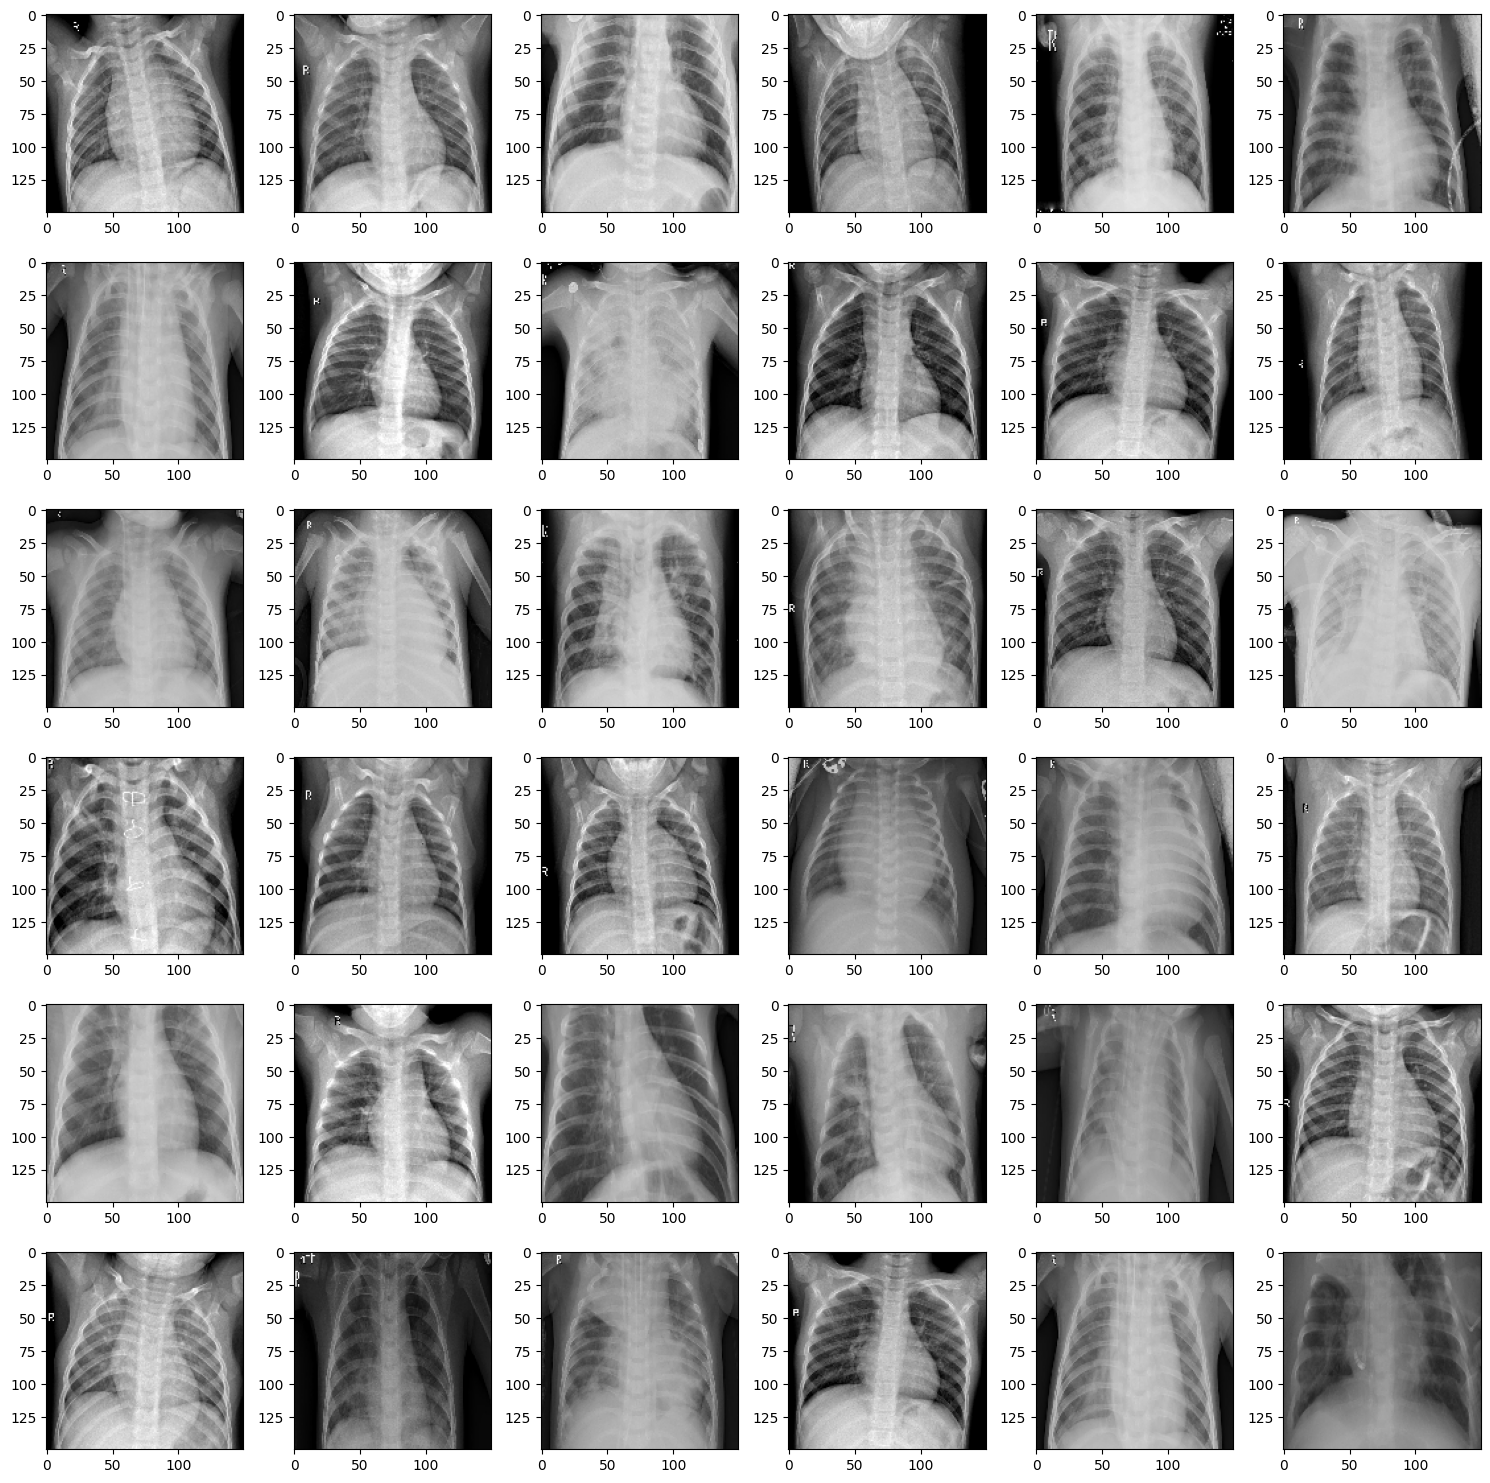

In [26]:
seed = 7
random.seed(seed)

visual_sample = [sample_training_images[int(random.random()*100)] for i in range(36)]

plotImages(visual_sample, 6, 6)

Acima podemos ver que as algumas imagens possuem uma leve rotação, outras possuem uma iluminação mais acentuada, enquanto que outras apresentam o torax dos pacientes mais próximos do equipamento de Raio-X. Essas alterações nas imagens podem ser simuladas através da técnica de aumentação do dataset caso o desempenho do modelo esteja abaixo do esperado.

## 4. Criação do modelo base

Abaixo iremos definir a arquitetura da rede neural convolucional para compilarmos o nosso modelo e posteriormente treina-lo. A rede consiste de 4 camadas convolucionais seguidas de camadas de max polling. Nos também usamos uma camada de droupout para ajudar na prevenção de overfitting. A camada do dropout desliga randomicamente alguns neurônios à medida que os dados passam pelas épocas, forçando os outros neurônios a fazer todo o trabalho. O modelo irá retornar a probabilidade de uma classe ser Normal ou Pneumonia.

In [27]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

Para compilar o modelo iremos utilizar otimizador adam,

In [28]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

Como tecnica complementar para evitar overfitting e economizar tempo durante o treinamento iremos usar o método de parada adiantada. Iremos monitorar a métrica de perda (loss) do conjunto de validação durante a fase de treinamento, e usá-la para determinar quando parar o treiamento do modelo quando o mesmo estiver com um bom desempenho e não apresentar overfitting.

In [29]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

Abaixo temos a arquitetura do modelo.

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

Para treinar o modelo, iremos usar a proporção entre as classes para dar um peso maior à classe **NORMAL**. Dessa forma teremos um tratamento mais justo uma vez que esta classe esta em menor proporção, i.e, desbalanceada.

In [31]:
EPOCHS = 100
class_weight = num_pneumonia_tr/num_normal_tr

history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))),
    callbacks=[early_stopping],
    class_weight={0: class_weight, 1: 1.0}
)

Epoch 1/100
36/36 [==============================] - 73s 2s/step - loss: 0.8957 - accuracy: 0.5296 - precision: 0.8769 - recall: 0.4047 - val_loss: 0.2833 - val_accuracy: 0.8967 - val_precision: 0.9583 - val_recall: 0.8999
Epoch 2/100
36/36 [==============================] - 59s 2s/step - loss: 0.3912 - accuracy: 0.8884 - precision: 0.9601 - recall: 0.8821 - val_loss: 0.1742 - val_accuracy: 0.9351 - val_precision: 0.9794 - val_recall: 0.9321
Epoch 3/100
36/36 [==============================] - 57s 2s/step - loss: 0.3569 - accuracy: 0.9050 - precision: 0.9657 - recall: 0.9002 - val_loss: 0.2561 - val_accuracy: 0.9009 - val_precision: 0.9871 - val_recall: 0.8780
Epoch 4/100
36/36 [==============================] - 57s 2s/step - loss: 0.2673 - accuracy: 0.9271 - precision: 0.9754 - recall: 0.9223 - val_loss: 0.1617 - val_accuracy: 0.9394 - val_precision: 0.9854 - val_recall: 0.9321
Epoch 5/100
36/36 [==============================] - 57s 2s/step - loss: 0.1993 - accuracy: 0.9479 - precisi

In [32]:
# Carrega uma folha de estilos (opcional - questões estéticas)
plt.style.use("ggplot")

# Modifica mais alguns parâmetros gráficos (opcional - questões estéticas)
plt.rc("axes", facecolor="#fafafa", grid = True)
plt.rc("grid", color = "#f0f0f0")
plt.rc("axes", edgecolor="#cccccc", lw=0.1)

In [33]:
def f1_score_array(precision_train, precision_val, recall_train, recall_val):
    """
    INPUT:
    precision_train: a array with the precision metric for train
    precision_val: a array with the precision metric for Validation
    recall_train: a array with the recall metric for train
    recall_val: a array with the recall metric for Validation

    OUTPUT:
    f1_score_train: a array with the f1 score metric for train
    f1_score_val: a array with the f1 score metric for validation

    DESCRIPTION:
    This function calculate F1 score using harmonic mean to train and validation
    """

    precision_train_ = np.array(precision_train)
    precision_val_ = np.array(precision_val)
    recall_train_ = np.array(recall_train)
    recall_val_ = np.array(recall_val)

    f1_score_train = 2*(precision_train_*recall_train_)/(precision_train_+recall_train_)
    f1_score_val = 2*(precision_val_*recall_val_)/(precision_val_+recall_val_)

    return list(f1_score_train), list(f1_score_val)

In [86]:
pip install python-Levenshtein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 9.0 MB/s eta 0:00:00


In [102]:
import Levenshtein

def find_match(string, array):
    """
    INPUT:
    string: a string we want to find a match
    array: a array with strings

    OUTPUT:
    sort_similarities[0][0]: a string more close to be a match

    DESCRIPTION:
    This function search in a array the string more close to be a match
    """
    similarities = [(item, Levenshtein.distance(string, item)) for item in array]
    sort_similarities = sorted(similarities, key=lambda x: x[1])
    return sort_similarities[0][0]

def plot_performance(history):
    """
    INPUT:
    history: the history with all metrics gathered during a model training

    DESCRIPTION:
    This function plots 5 charts comparing the validation curves with
    training ones.
    """
    keys = history.history.keys()
    metrics_train = {'loss': [], 'accuracy': [], 'precision': [], 'recall': []}
    metrics_val = {'val_loss': [], 'val_accuracy': [], 'val_precision': [], 'val_recall': []}

    for key in metrics_train.keys():
        metric = find_match(key, keys)
        metrics_train[key] = history.history[metric]

    for key in metrics_val.keys():
        metric = find_match(key, keys)
        metrics_val[key] = history.history[metric]

    f1, val_f1 = f1_score_array(metrics_train['precision'], metrics_val['val_precision'], metrics_train['recall'], metrics_val['val_recall'])

    epochs_range = range(len(metrics_train['accuracy']))

    fig, ax = plt.subplots(1, 5,  figsize=(20, 5))

    ax[0].plot(epochs_range, metrics_train['loss'], label='Training Loss')
    ax[0].plot(epochs_range, metrics_val['val_loss'], label='Validation Loss')
    ax[0].legend(loc='upper right')
    ax[0].set_title('Loss')

    ax[1].plot(epochs_range, metrics_train['accuracy'], label='Training Accuracy')
    ax[1].plot(epochs_range, metrics_val['val_accuracy'], label='Validation Accuracy')
    ax[1].legend(loc='lower right')
    ax[1].set_title('Accuracy')

    ax[2].plot(epochs_range, f1, label='Training F1 Score')
    ax[2].plot(epochs_range, val_f1, label='Validation F1 Score')
    ax[2].legend(loc='center right')
    ax[2].set_title('F1 Score')

    ax[3].plot(epochs_range, metrics_train['precision'], label='Training Precision')
    ax[3].plot(epochs_range, metrics_val['val_precision'], label='Validation Precision')
    ax[3].legend(loc='lower right')
    ax[3].set_title('Precision')

    ax[4].plot(epochs_range, metrics_train['recall'], label='Training Recall')
    ax[4].plot(epochs_range, metrics_val['val_recall'], label='Validation Recall')
    ax[4].legend(loc='lower right')
    ax[4].set_title('Recall')

    plt.show()

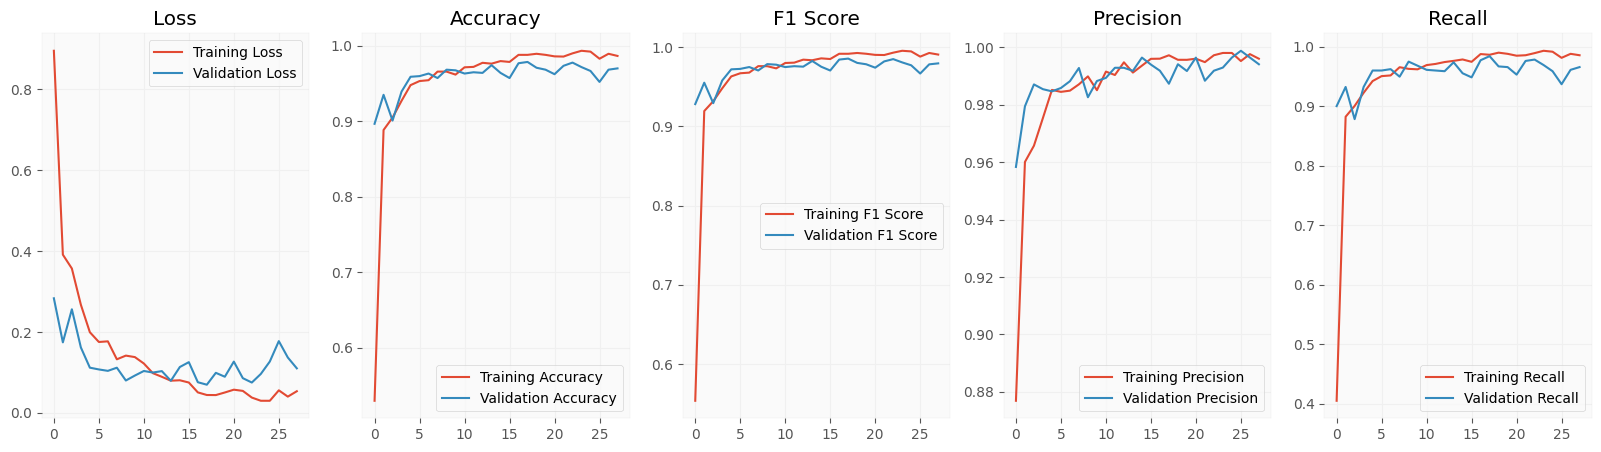

In [103]:
plot_performance(history)

Analizando o primeiro gráfico na curva de loss, vemos que a curva de validação vai se afastando ao longo do tempo da curva de treino. Enquando a curva de treino apresenta tendência de queda, a curva de validação apresenta tendência de subida, o que é uma evidência de overfitting. Porém como usamos o early stopping, o modelo foi preservado durante o treinamento antes de adquirir o overfitting. Porém podemos melhorar as métricas usando data augmentation.

In [35]:
import math
test_loss, test_accuracy, test_precicion, test_recall = model.evaluate(test_data_gen, steps=math.ceil(total_test/BATCH_SIZE))
print('Métrica de perda nos dados de teste:', test_loss)
print('Métrica de acurácia nos dados de teste:', test_accuracy)
print('Métrica de precisão nos dados de teste:', test_precicion)
print('Métrica de recall nos dados de teste:', test_recall)

f1_score = 2*(test_precicion*test_recall)/(test_precicion+test_recall)
print('Métrica de F1 score nos dados de teste:', f1_score)

12/12 [==============================] - 11s 756ms/step - loss: 0.8917 - accuracy: 0.8548 - precision: 0.8423 - recall: 0.9896
Métrica de perda nos dados de teste: 0.891743004322052
Métrica de acurácia nos dados de teste: 0.854824960231781
Métrica de precisão nos dados de teste: 0.842311441898346
Métrica de recall nos dados de teste: 0.9896432757377625
Métrica de F1 score nos dados de teste: 0.9100529030841006


In [36]:
import joblib

def save_model(model, model_filepath):
    """
    INPUT
        model - a trained model
        model_filepath - a file path to store the trained model
    """
    joblib.dump(model, model_filepath)

In [37]:
save_model(model, 'chest-xray-classifier-I.pkl')

## 5. Experimentos com data augmentation

### 5.1 Rotação

Lá em cima identificamos que algumas imagens apresentam diferenças na rotação.

Abaixo iremos rotular o ângulo de rotação das imagens de treino para ter uma ideia de qual valor máximo as imagens estão rotaciodas. Para isso iremos pegar apenas a parte da imagem de raio-x referente à coluna vertebral, segmentar a imagem usando a técnica de limiarização e depois aplicar a transformada de hough. Pegamos então a mediana das linhas geradas através da transformada de hough para pegar a linha que melhor representa a rotação da coluna vertebral, e então calculamos o ângulo de rotação.

In [38]:
def get_spine_space(image):
    """
    INPUT
    image: a image in RGB format

    OUTPUT
    cut_image: a grayscale image of the spine

    DESCRIPTION
    This function return a grayscale image of the spine
    """

    # Get image dimensions
    height, width = image.shape[:2]

    # Calculate the amount of pixels to crop
    side_cut_pixels = int(width * 0.4)
    inferior_cut_pixels = int(height * 0.2)

    # Convert image to grayscale
    img_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # cut the image
    cut_image = img_grey[inferior_cut_pixels:-inferior_cut_pixels,
                        side_cut_pixels:-side_cut_pixels]

    return cut_image


def get_spine_line(image):
    """
    INPUT
    image: a image in grayscale format

    OUTPUT
    rho: median of rho parameters of the hough lines
    theta: median of theta parameters of the hough lines

    DESCRIPTION
    Calculate the median of the rho and theta parameters of the hough lines
    """

    # Equalizar o histograma
    equalized_image = cv2.equalizeHist(image)

    # Get the max value of pixel in the image
    max_value = np.max(equalized_image)

    """
    Based on this max value, we segment the image using Segmentation by
    thresholding. We know that the spine has lighter pixels, so we binarize
    the image using the knowlegde.
    """
    _, segmented_image = cv2.threshold(equalized_image, max_value-30, 255,
                                         cv2.THRESH_BINARY)

    # Set the desired keystone limits (in radians)
    min_angle_rad = np.deg2rad(160)
    max_angle_rad = np.deg2rad(200)

    """
    The threshold_max is the minimum value needed to consider a valid line.
    To do so, we get the total white pixels in the segmented image, and use
    0.95% of this total to consider the minimum amount needed to create a valid
    line.
    """
    threshold_max = int(np.sum(segmented_image == 255)*0.0096)

    # Apply the Hough Transform
    lines = cv2.HoughLines(segmented_image, 1, np.pi/180, threshold=threshold_max,
                            min_theta=min_angle_rad, max_theta=max_angle_rad)

    # Calculate the median of the rho and theta parameters of the lines
    rho = None
    theta = None
    if lines is not None:
      rho = np.median(lines[:, :, 0])
      theta = np.median(lines[:, :, 1])

    return rho, theta


def drawn_line_in_image(image, rho, theta):
    """
    INPUT
    image: a image in grayscale format
    rho: median of rho parameters of the hough lines
    theta: median of theta parameters of the hough lines

    OUTPUT
    image: image with the line drawed;
    degree_angle_rotation: the angle of rotation the degrees

    DESCRIPTION
    This function dran the line in the cutted image and calculate the the angle
    of rotation the degrees
    """

    degree_angle_rotation = None
    if theta is not None and rho is not None:
      # Convert median rho and theta to x and y coordinates
      a = np.cos(theta)
      b = np.sin(theta)
      x0 = a * rho
      y0 = b * rho

      # Define the start and end points of the midline
      x1 = int(x0 + 1000 * (-b))
      y1 = int(y0 + 1000 * (a))
      x2 = int(x0 - 1000 * (-b))
      y2 = int(y0 - 1000 * (a))

      # Draw the midline on the cuted image
      cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), 2)

      # Calculate line rotation angle
      degree_angle_rotation = abs(180-np.degrees(theta))

    return image, degree_angle_rotation

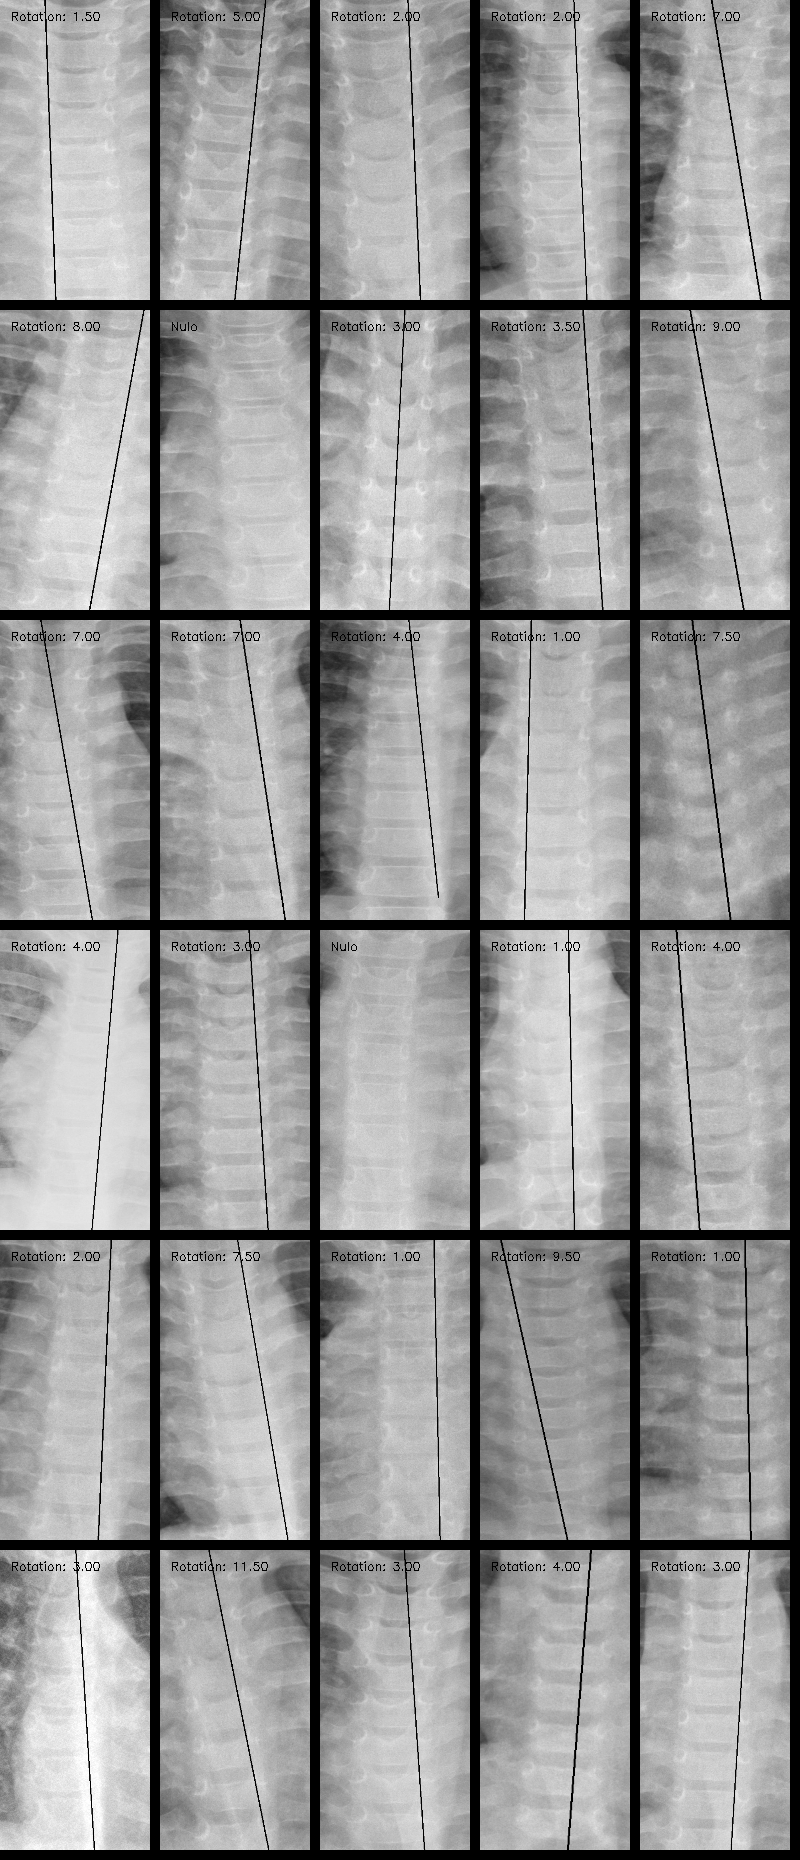

In [39]:
seed = 7
random.seed(seed)

# Directory where the images are
images_dir = 'dataset/chest_xray/train/NORMAL/*'

# List of image files in the directory
image_files = glob.glob(images_dir)

# Randomly choose 4 images
random_path_images = random.sample(image_files, 30)
resized_images = []
legends = []
random_images = [cv2.imread(path) for path in random_path_images]

height_img = 300
width_img = 150

for i, image in enumerate(random_images):
  cut_image = get_spine_space(image.copy())
  rho, theta = get_spine_line(cut_image)
  new_cut_image, degree_angle_rotation = drawn_line_in_image(cut_image, rho, theta)

  resized_images.append(cv2.resize(new_cut_image, (width_img, height_img)))

  legend = 'Nulo'
  if degree_angle_rotation is not None:
    legend = "Rotation: {:.2f}".format(degree_angle_rotation)

  legends.append(legend)

# Criar um grid 6x5 com as imagens e os textos
spacing = 10

height_grid = (height_img + spacing) * 6
width_grid = (width_img + spacing) * 5

grid = np.zeros((height_grid, width_grid), dtype=np.uint8)

for i, image in enumerate(resized_images):
    x = (i % 5) * (width_img + spacing)
    y = (i // 5) * (height_img + spacing)

    grid[y:y+height_img, x:x+width_img] = image
    cv2.putText(grid, legends[i], (x+10, y+20), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)

cv2_imshow(grid)

Acima vemos que pouco mais da metade das imagens conseguiu traçar uma linha reta bem alinhada à coluna vertebral, o que representa a rotação da imagem. Iremos então criar um dataframe rotulando as imagens de treino com o ângulo de rotação, para ter uma leve ideia desses valores.

In [40]:
# Directory where the images are
images_dir = 'dataset/chest_xray/train/NORMAL/*'

# List of image files in the directory
image_files = glob.glob(images_dir)

df = pd.DataFrame(columns=["imagem", "rotação"])

for i, path in enumerate(image_files):
  image = cv2.imread(path)
  cut_image = get_spine_space(image.copy())
  rho, theta = get_spine_line(cut_image)
  _, degree_angle_rotation = drawn_line_in_image(cut_image, rho, theta)
  df = df.append({"imagem": image_files[i], "rotação": degree_angle_rotation}, ignore_index=True)

In [41]:
# Directory where the images are
images_dir = 'dataset/chest_xray/train/PNEUMONIA/*'

# List of image files in the directory
image_files = glob.glob(images_dir)

for i, path in enumerate(image_files):
  image = cv2.imread(path)
  cut_image = get_spine_space(image.copy())
  rho, theta = get_spine_line(cut_image)
  _, degree_angle_rotation = drawn_line_in_image(cut_image, rho, theta)
  df = df.append({"imagem": image_files[i], "rotação": degree_angle_rotation}, ignore_index=True)

In [42]:
df.describe()

rotação
count  3222.000000
mean      3.832870
std       3.142174
min       0.000015
25%       1.000015
50%       3.000015
75%       5.999985
max      18.000015

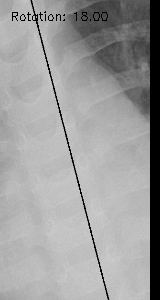

In [43]:
paths = list(df[df['rotação'] > 18]['imagem'])
resized_images = []
legends = []

for i, path in enumerate(paths):
  image = cv2.imread(path)
  cut_image = get_spine_space(image.copy())
  rho, theta = get_spine_line(cut_image)
  new_cut_image, degree_angle_rotation = drawn_line_in_image(cut_image, rho, theta)

  resized_images.append(cv2.resize(new_cut_image, (width_img, height_img)))

  legend = 'Nulo'
  if degree_angle_rotation is not None:
    legend = "Rotation: {:.2f}".format(degree_angle_rotation)

  legends.append(legend)

lenght = len(resized_images)
height_grid = height_img
width_grid = (width_img + spacing) * lenght

grid = np.zeros((height_grid, width_grid), dtype=np.uint8)

for i, image in enumerate(resized_images):
    x = (i % lenght) * (width_img + spacing)

    grid[0:height_img, x:x+width_img] = image
    cv2.putText(grid, legends[i], (x+10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)

cv2_imshow(grid)

Acima podemos ver que a rotação mínima é 0º e a rotação máxima das imagens é de aproximadamente 19º. Também podemos ver que a imagem acima foi rotulada corretamente com o angulo de 18º, i.e, a linha esta bem direcionada em relação à coluna vertebral. Logo, podemos utilizar este valor para aumentar nossos dados com rotações.

In [44]:
train_image_generator2 = ImageDataGenerator(
                                          rescale=1./255,
                                          rotation_range=18)  # Generator for our training data

train_data_gen2 = train_image_generator2.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                           class_mode='binary')

Found 3514 images belonging to 2 classes.


Abaixo podemos ver um pouco de como nossas imagens ficam usando aumento de dados de rotação com até 18º.

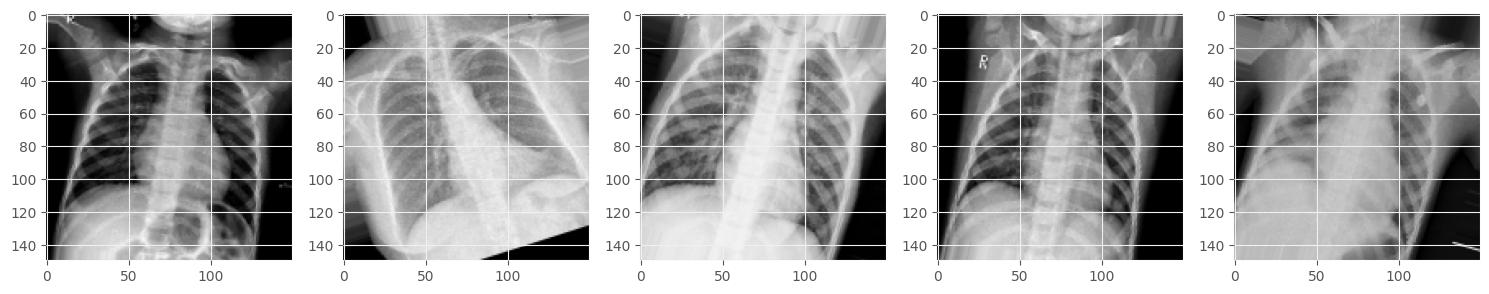

In [45]:
seed = 7
random.seed(seed)

sample_training_images, _ = next(train_data_gen2)
visual_sample = [sample_training_images[int(random.random()*100)] for i in range(5)]
plotImages(visual_sample, 1, 5)

In [46]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [47]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [48]:
early_stopping2 = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [49]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 17, 17, 128)     

In [50]:
history2 = model2.fit(
    train_data_gen2,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))),
    callbacks=[early_stopping2],
    class_weight={0: class_weight, 1: 1.0}
)

Epoch 1/100
36/36 [==============================] - 82s 2s/step - loss: 0.9826 - accuracy: 0.5054 - precision_1: 0.7816 - recall_1: 0.4363 - val_loss: 0.8059 - val_accuracy: 0.3117 - val_precision_1: 1.0000 - val_recall_1: 0.0725
Epoch 2/100
36/36 [==============================] - 75s 2s/step - loss: 0.5711 - accuracy: 0.8099 - precision_1: 0.9435 - recall_1: 0.7834 - val_loss: 0.3399 - val_accuracy: 0.8574 - val_precision_1: 0.9821 - val_recall_1: 0.8228
Epoch 3/100
36/36 [==============================] - 85s 2s/step - loss: 0.3460 - accuracy: 0.9010 - precision_1: 0.9655 - recall_1: 0.8947 - val_loss: 0.3332 - val_accuracy: 0.8668 - val_precision_1: 0.9890 - val_recall_1: 0.8297
Epoch 4/100
36/36 [==============================] - 74s 2s/step - loss: 0.3124 - accuracy: 0.9172 - precision_1: 0.9698 - recall_1: 0.9136 - val_loss: 0.2255 - val_accuracy: 0.9086 - val_precision_1: 0.9860 - val_recall_1: 0.8895
Epoch 5/100
36/36 [==============================] - 72s 2s/step - loss: 0.3

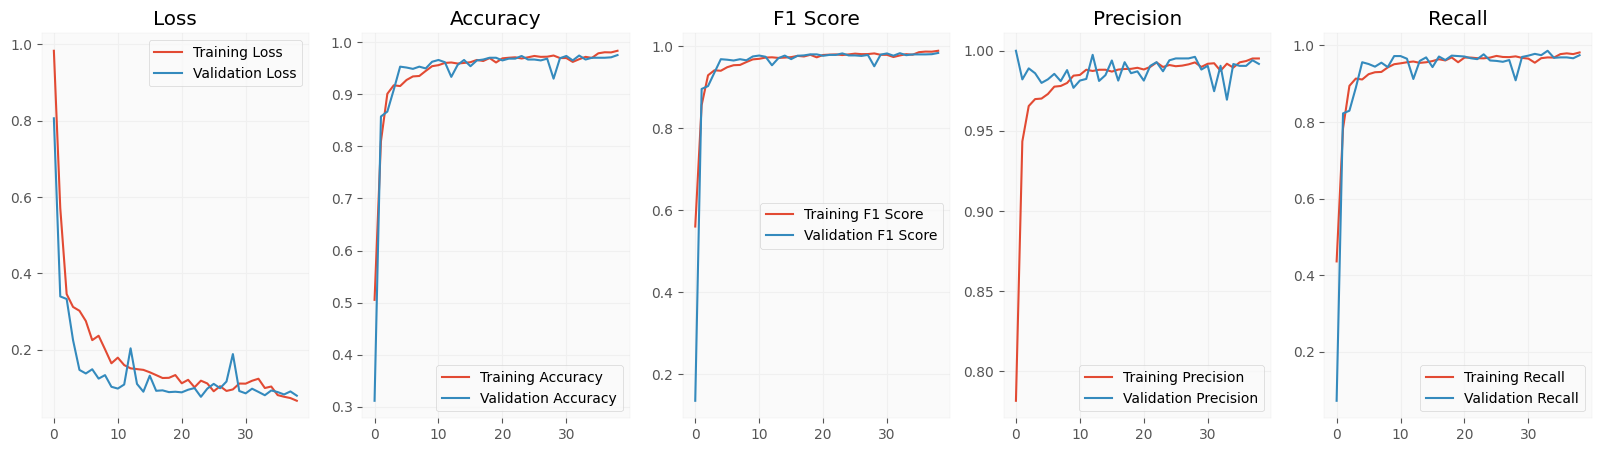

In [104]:
plot_performance(history2)

A curva de perda apresentou ótimos resultados. Ambos apresentam tendência de queda. Porém existem dois picos na curva de perda um pouco acentuados que ultraparam a curva de treinamento numa tendência de ascenção, o que pode indicar overfitting.

In [52]:
test_loss, test_accuracy, test_precicion, test_recall = model2.evaluate(test_data_gen, steps=math.ceil(total_test/BATCH_SIZE))
print('Métrica de perda nos dados de teste:', test_loss)
print('Métrica de acurácia nos dados de teste:', test_accuracy)
print('Métrica de precisão nos dados de teste:', test_precicion)
print('Métrica de recall nos dados de teste:', test_recall)

f1_score = 2*(test_precicion*test_recall)/(test_precicion+test_recall)
print('Métrica de F1 score nos dados de teste:', f1_score)

12/12 [==============================] - 11s 843ms/step - loss: 0.5058 - accuracy: 0.8719 - precision_1: 0.8606 - recall_1: 0.9873
Métrica de perda nos dados de teste: 0.5057546496391296
Métrica de acurácia nos dados de teste: 0.8719043731689453
Métrica de precisão nos dados de teste: 0.8605817556381226
Métrica de recall nos dados de teste: 0.9873417615890503
Métrica de F1 score nos dados de teste: 0.9196141492675055


O resultado do F1-Score apresenta um melhor resultado do que o anterior. Porém talvez possamos melhorar o modelo ainda mais, visto que aplicações médicas necessitam de classificadores mais precisos.

In [53]:
save_model(model2, 'chest-xray-classifier-II.pkl')

## 5.2 Melhorias na rotação

Uma das hipoteses é de que as rotações de 18º tenham sido muito exageradas. Podemos pensar em cenários onde já existia uma rotação de 10º por exemplo, e ao aplicar uma rotação de 18º nesta imagem, teriamos uma rotação de 28º por exemplo onde extrapolariamos os exemplos da base, fazendo o modelo treinar em cima de exemplos fora da realizada da base.

<Axes: ylabel='rotação'>

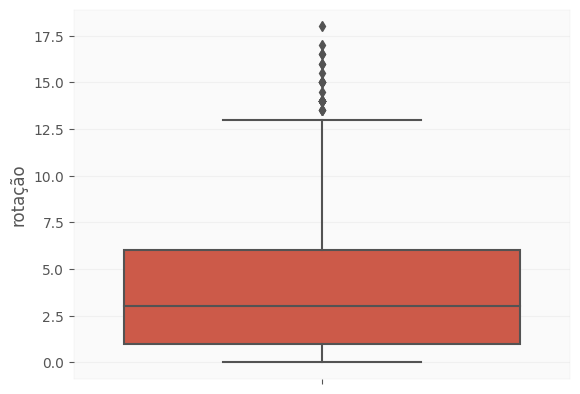

In [54]:
# Plota o boxplot no segundo eixo
import seaborn as sns
sns.boxplot(y='rotação', data=df)

Acima vemos que o intervalo interquartil esta aproximadamente entre 1,5º e 6º. Ou seja 50% da base possuem rotações entre esses valores. Logo, podemos usar o terceiro percentil para podemos aumentar a nossa base.

In [55]:
df.describe().loc['75%']

rotação    5.999985
Name: 75%, dtype: float64

In [56]:
train_image_generator3 = ImageDataGenerator(
                                          rescale=1./255,
                                          rotation_range=6)  # Generator for our training data

train_data_gen3 = train_image_generator3.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                           class_mode='binary')

Found 3514 images belonging to 2 classes.


Abaixo podemos ver um pouco de como nossas imagens ficam usando aumento de dados de rotação com até 6º. Algo um pouco mais próximo dos exemplos que vimos inicialmente.

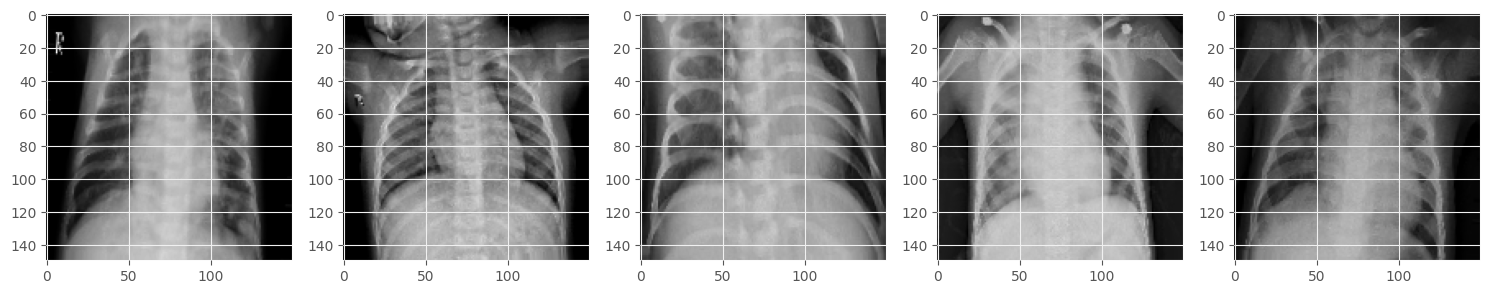

In [57]:
seed = 7
random.seed(seed)

sample_training_images, _ = next(train_data_gen3)
visual_sample = [sample_training_images[int(random.random()*100)] for i in range(5)]
plotImages(visual_sample, 1, 5)

In [58]:
model3 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [59]:
model3.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [60]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 17, 17, 128)     

In [61]:
history3 = model3.fit(
    train_data_gen3,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))),
    callbacks=[early_stopping2],
    class_weight={0: class_weight, 1: 1.0}
)

Epoch 1/100
36/36 [==============================] - 84s 2s/step - loss: 0.9026 - accuracy: 0.5754 - precision_2: 0.8584 - recall_2: 0.4927 - val_loss: 0.3296 - val_accuracy: 0.8779 - val_precision_2: 0.9172 - val_recall_2: 0.9183
Epoch 2/100
36/36 [==============================] - 73s 2s/step - loss: 0.3622 - accuracy: 0.9018 - precision_2: 0.9628 - recall_2: 0.8986 - val_loss: 0.2360 - val_accuracy: 0.9103 - val_precision_2: 0.9910 - val_recall_2: 0.8872
Epoch 3/100
36/36 [==============================] - 73s 2s/step - loss: 0.2487 - accuracy: 0.9260 - precision_2: 0.9734 - recall_2: 0.9227 - val_loss: 0.1305 - val_accuracy: 0.9582 - val_precision_2: 0.9881 - val_recall_2: 0.9551
Epoch 4/100
36/36 [==============================] - 73s 2s/step - loss: 0.1957 - accuracy: 0.9471 - precision_2: 0.9823 - recall_2: 0.9436 - val_loss: 0.1156 - val_accuracy: 0.9599 - val_precision_2: 0.9893 - val_recall_2: 0.9563
Epoch 5/100
36/36 [==============================] - 73s 2s/step - loss: 0.1

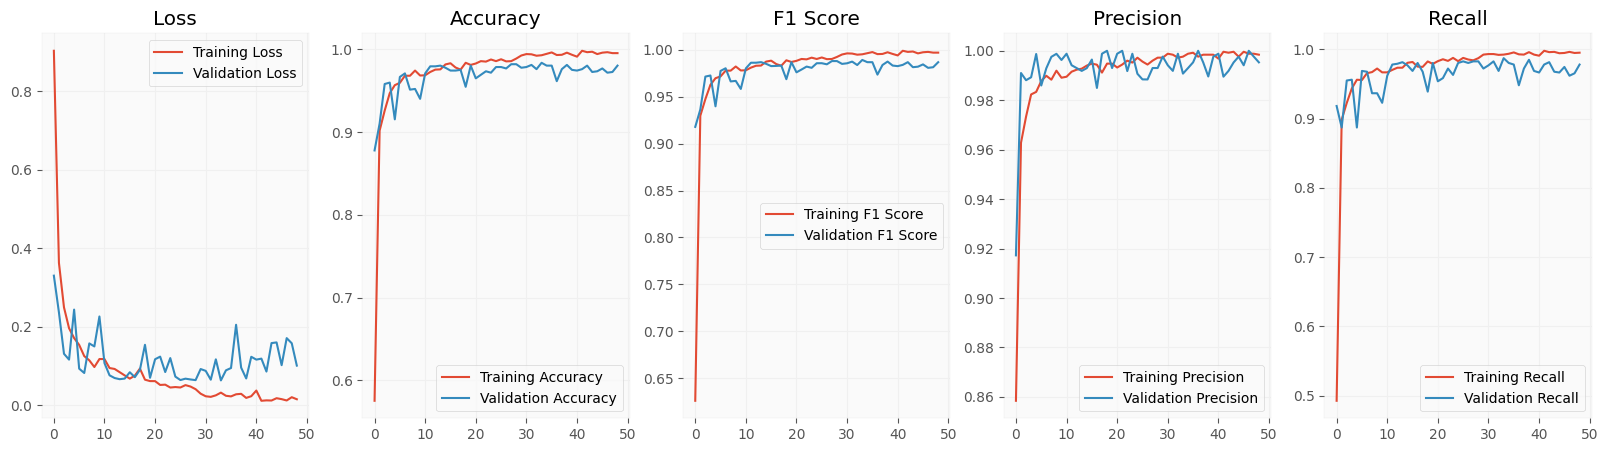

In [105]:
plot_performance(history3)

Aqui, os picos são ainda mais acentuados que no experimento de anterior. E as curvas de loss vão em direções contrárias. Enquanto a de treino esta em queda a de validação esta ascendente, indicando overfitting.

In [64]:
test_loss, test_accuracy, test_precicion, test_recall = model3.evaluate(test_data_gen, steps=math.ceil(total_test/BATCH_SIZE))
print('Métrica de perda nos dados de teste:', test_loss)
print('Métrica de acurácia nos dados de teste:', test_accuracy)
print('Métrica de precisão nos dados de teste:', test_precicion)
print('Métrica de recall nos dados de teste:', test_recall)

f1_score = 2*(test_precicion*test_recall)/(test_precicion+test_recall)
print('Métrica de F1 score nos dados de teste:', f1_score)

12/12 [==============================] - 11s 858ms/step - loss: 1.1337 - accuracy: 0.8659 - precision_2: 0.8532 - recall_2: 0.9896
Métrica de perda nos dados de teste: 1.1336700916290283
Métrica de acurácia nos dados de teste: 0.8659265637397766
Métrica de precisão nos dados de teste: 0.85317462682724
Métrica de recall nos dados de teste: 0.9896432757377625
Métrica de F1 score nos dados de teste: 0.9163559039603699


O resultados do F1-score para base de teste apresentou um resultado um pouco mais inferior também.

In [65]:
save_model(model3, 'chest-xray-classifier-III.pkl')

## 5.3 Zoom

Vamos tentar outra abordagem de aumento de dados, usando zoom desta vez. Porém, com a falta de conhecimento para aplicar uma técnica para medir o zoom nas imagens iremos seguir pela tentativa e erro. Começado com um zoom de 0.3.

In [66]:
train_image_generator4 = ImageDataGenerator(
                                          rescale=1./255,
                                          zoom_range=0.3)  # Generator for our training data

train_data_gen4 = train_image_generator4.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                           class_mode='binary')

Found 3514 images belonging to 2 classes.


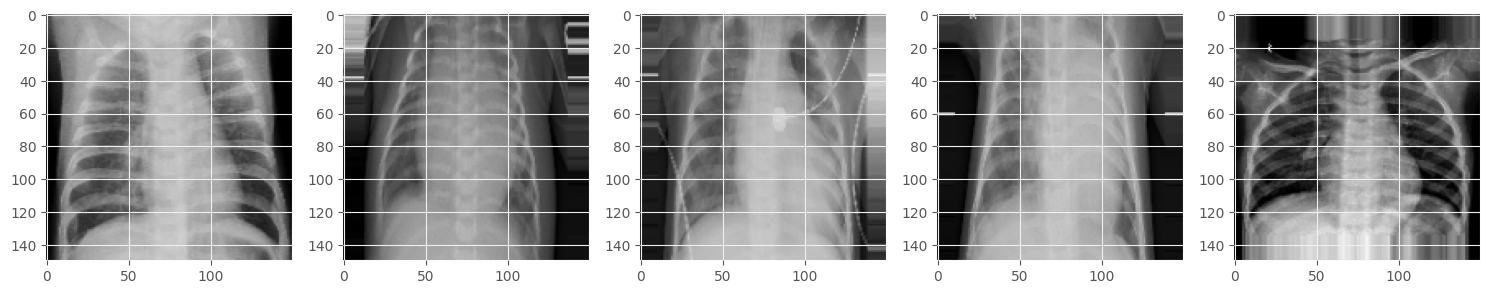

In [67]:
seed = 7
random.seed(seed)

sample_training_images, _ = next(train_data_gen4)
visual_sample = [sample_training_images[int(random.random()*100)] for i in range(5)]
plotImages(visual_sample, 1, 5)

In [68]:
model4 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [70]:
model4.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [71]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 17, 17, 128)     

In [72]:
history4 = model4.fit(
    train_data_gen4,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))),
    callbacks=[early_stopping],
    class_weight={0: class_weight, 1: 1.0}
)

Epoch 1/100
36/36 [==============================] - 93s 3s/step - loss: 0.9832 - accuracy: 0.5504 - precision_4: 0.7727 - recall_4: 0.5337 - val_loss: 0.8655 - val_accuracy: 0.2656 - val_precision_4: 1.0000 - val_recall_4: 0.0104
Epoch 2/100
36/36 [==============================] - 78s 2s/step - loss: 0.6584 - accuracy: 0.7925 - precision_4: 0.9177 - recall_4: 0.7826 - val_loss: 0.7751 - val_accuracy: 0.6960 - val_precision_4: 0.9981 - val_recall_4: 0.5915
Epoch 3/100
36/36 [==============================] - 83s 2s/step - loss: 0.5236 - accuracy: 0.8512 - precision_4: 0.9397 - recall_4: 0.8481 - val_loss: 0.3306 - val_accuracy: 0.8420 - val_precision_4: 0.9803 - val_recall_4: 0.8032
Epoch 4/100
36/36 [==============================] - 76s 2s/step - loss: 0.4319 - accuracy: 0.8739 - precision_4: 0.9552 - recall_4: 0.8659 - val_loss: 0.2118 - val_accuracy: 0.9180 - val_precision_4: 0.9789 - val_recall_4: 0.9091
Epoch 5/100
36/36 [==============================] - 76s 2s/step - loss: 0.3

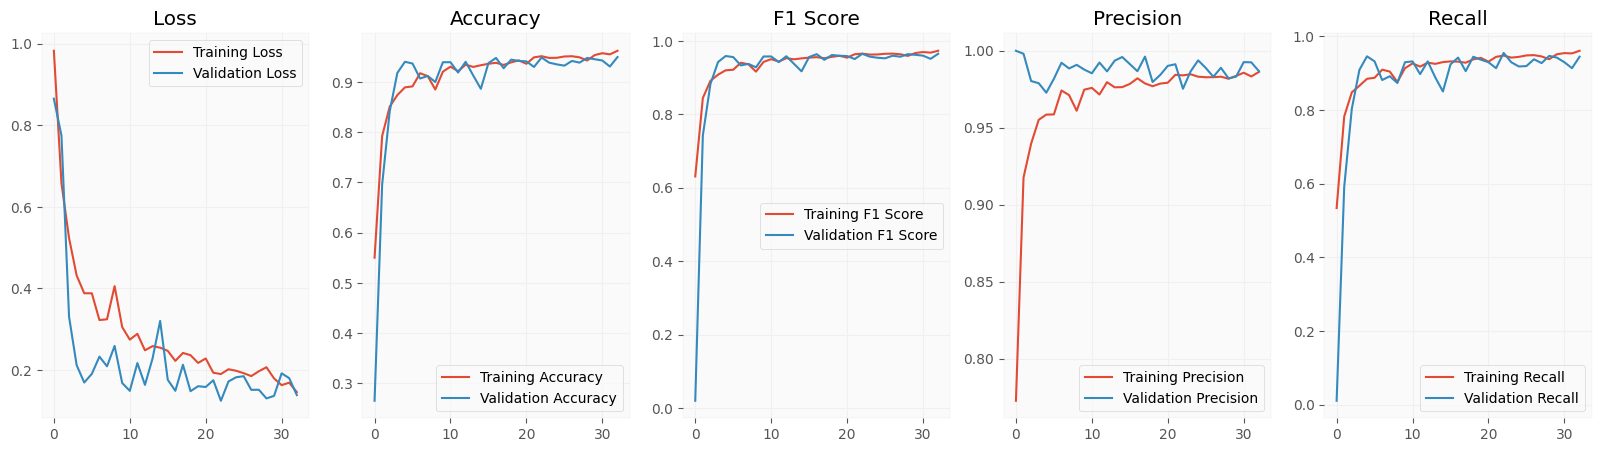

In [106]:
plot_performance(history4)

Acima temos o o resultado mais promissor de todos até o momento. Nos gráficos de acurácia e F1-score as curvas seguem bem próximas uma da outra. A curva de perda fica levemente acima da de treino em um dado momento porém, porém ela segue abaixo da curva de treinamento indicando um bom desempenho.

In [73]:
test_loss, test_accuracy, test_precicion, test_recall = model4.evaluate(test_data_gen, steps=math.ceil(total_test/BATCH_SIZE))
print('Métrica de perda nos dados de teste:', test_loss)
print('Métrica de acurácia nos dados de teste:', test_accuracy)
print('Métrica de precisão nos dados de teste:', test_precicion)
print('Métrica de recall nos dados de teste:', test_recall)

f1_score = 2*(test_precicion*test_recall)/(test_precicion+test_recall)
print('Métrica de F1 score nos dados de teste:', f1_score)

12/12 [==============================] - 12s 863ms/step - loss: 0.2008 - accuracy: 0.9317 - precision_4: 0.9448 - recall_4: 0.9643
Métrica de perda nos dados de teste: 0.20075473189353943
Métrica de acurácia nos dados de teste: 0.9316823482513428
Métrica de precisão nos dados de teste: 0.9447575807571411
Métrica de recall nos dados de teste: 0.964326798915863
Métrica de F1 score nos dados de teste: 0.9544418919388761


Ainda temos o melhor resultado para as métricas de F1, tornando o melhor modelo até o momento.

In [74]:
save_model(model4, 'chest-xray-classifier-IV.pkl')

## 5.5 Rotação + Zoom

Será que conseguimos melhorar nosso desempenho usando rotação e zoom juntos?

In [75]:
train_image_generator5 = ImageDataGenerator(
                                          rescale=1./255,
                                          rotation_range=18,
                                          zoom_range=0.3,
                                          )  # Generator for our training data

train_data_gen5 = train_image_generator5.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                           class_mode='binary')

Found 3514 images belonging to 2 classes.


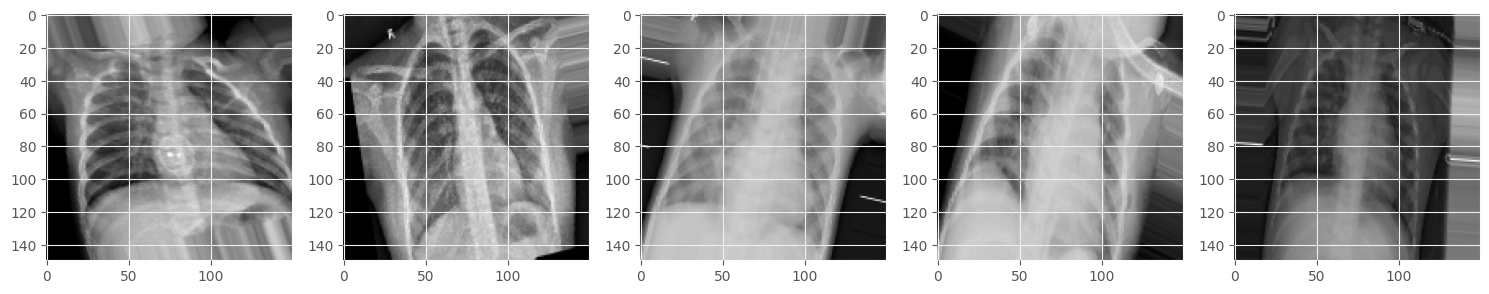

In [76]:
seed = 7
random.seed(seed)

sample_training_images, _ = next(train_data_gen5)
visual_sample = [sample_training_images[int(random.random()*100)] for i in range(5)]
plotImages(visual_sample, 1, 5)

In [77]:
model5 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [78]:
model5.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [79]:
model5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 17, 17, 128)     

In [80]:
history5 = model5.fit(
    train_data_gen5,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))),
    callbacks=[early_stopping],
    class_weight={0: class_weight, 1: 1.0}
)

Epoch 1/100
36/36 [==============================] - 82s 2s/step - loss: 1.0085 - accuracy: 0.4789 - precision_5: 0.7424 - recall_5: 0.4252 - val_loss: 0.7203 - val_accuracy: 0.2579 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 2/100
36/36 [==============================] - 76s 2s/step - loss: 0.7890 - accuracy: 0.6522 - precision_5: 0.9132 - recall_5: 0.5724 - val_loss: 0.2904 - val_accuracy: 0.8898 - val_precision_5: 0.9602 - val_recall_5: 0.8884
Epoch 3/100
36/36 [==============================] - 77s 2s/step - loss: 0.5233 - accuracy: 0.8438 - precision_5: 0.9394 - recall_5: 0.8375 - val_loss: 0.3499 - val_accuracy: 0.8454 - val_precision_5: 0.9845 - val_recall_5: 0.8044
Epoch 4/100
36/36 [==============================] - 77s 2s/step - loss: 0.4460 - accuracy: 0.8617 - precision_5: 0.9559 - recall_5: 0.8473 - val_loss: 0.4294 - val_accuracy: 0.8292 - val_precision_5: 0.9926 - val_recall_5: 0.7756
Epoch 5/100
36/36 [==============================] - 76s 2s/step - l

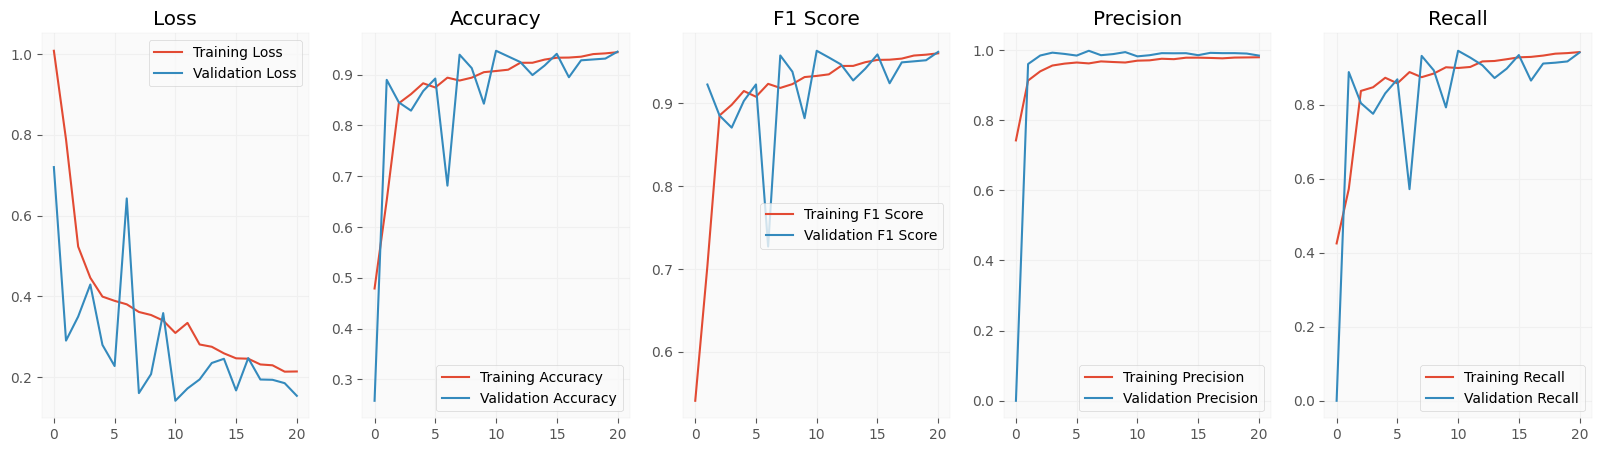

In [100]:
plot_performance(history5)

Temos alguns picos bem acentuados nos gráficos, porém na grande maior parte do tempo, a validação apresenta um desempenho superior ao treino nas métricas de Loss e precisão, o que não acontece com a acurária e F1-score.

In [81]:
test_loss, test_accuracy, test_precicion, test_recall = model5.evaluate(test_data_gen, steps=math.ceil(total_test/BATCH_SIZE))
print('Métrica de perda nos dados de teste:', test_loss)
print('Métrica de acurácia nos dados de teste:', test_accuracy)
print('Métrica de precisão nos dados de teste:', test_precicion)
print('Métrica de recall nos dados de teste:', test_recall)

f1_score = 2*(test_precicion*test_recall)/(test_precicion+test_recall)
print('Métrica de F1 score nos dados de teste:', f1_score)

12/12 [==============================] - 11s 845ms/step - loss: 0.2402 - accuracy: 0.9137 - precision_5: 0.9324 - recall_5: 0.9528
Métrica de perda nos dados de teste: 0.24024474620819092
Métrica de acurácia nos dados de teste: 0.9137489199638367
Métrica de precisão nos dados de teste: 0.9324324131011963
Métrica de recall nos dados de teste: 0.9528193473815918
Métrica de F1 score nos dados de teste: 0.9425156490515696


Nosso desempenho foi relativamente bom, porém inferior ao anterior, onde aplicamos apenas zoom como data augmentation.

In [82]:
save_model(model5, 'chest-xray-classifier-V.pkl')

In [149]:
def get_label(label):
    tag = 'Normal'
    if label > 0.5:
      tag = 'Pneumonia'

    return tag

def plotImages(images_arr, labels, predictions, n_row, n_col):
    """
    INPUT:
    images_arr: a array of images

    DESCRIPTION:
    This function plot images in a grid with 5 row by 6 columns,
    plotting each image in a column
    """
    fig, axes = plt.subplots(n_row, n_col, figsize=(n_col*5, n_row*5))
    axes = axes.flatten()
    for img, ax, label, pred in zip(images_arr, axes, labels, predictions):
        ax.imshow(img)
        tag_pred = get_label(pred)
        tag_true = get_label(label)

        title = 'Label: ' + tag_true + ' Pred: ' + tag_pred
        ax.set_title(title)

    plt.tight_layout()
    plt.show()

4/4 [==============================] - 0s 8ms/step


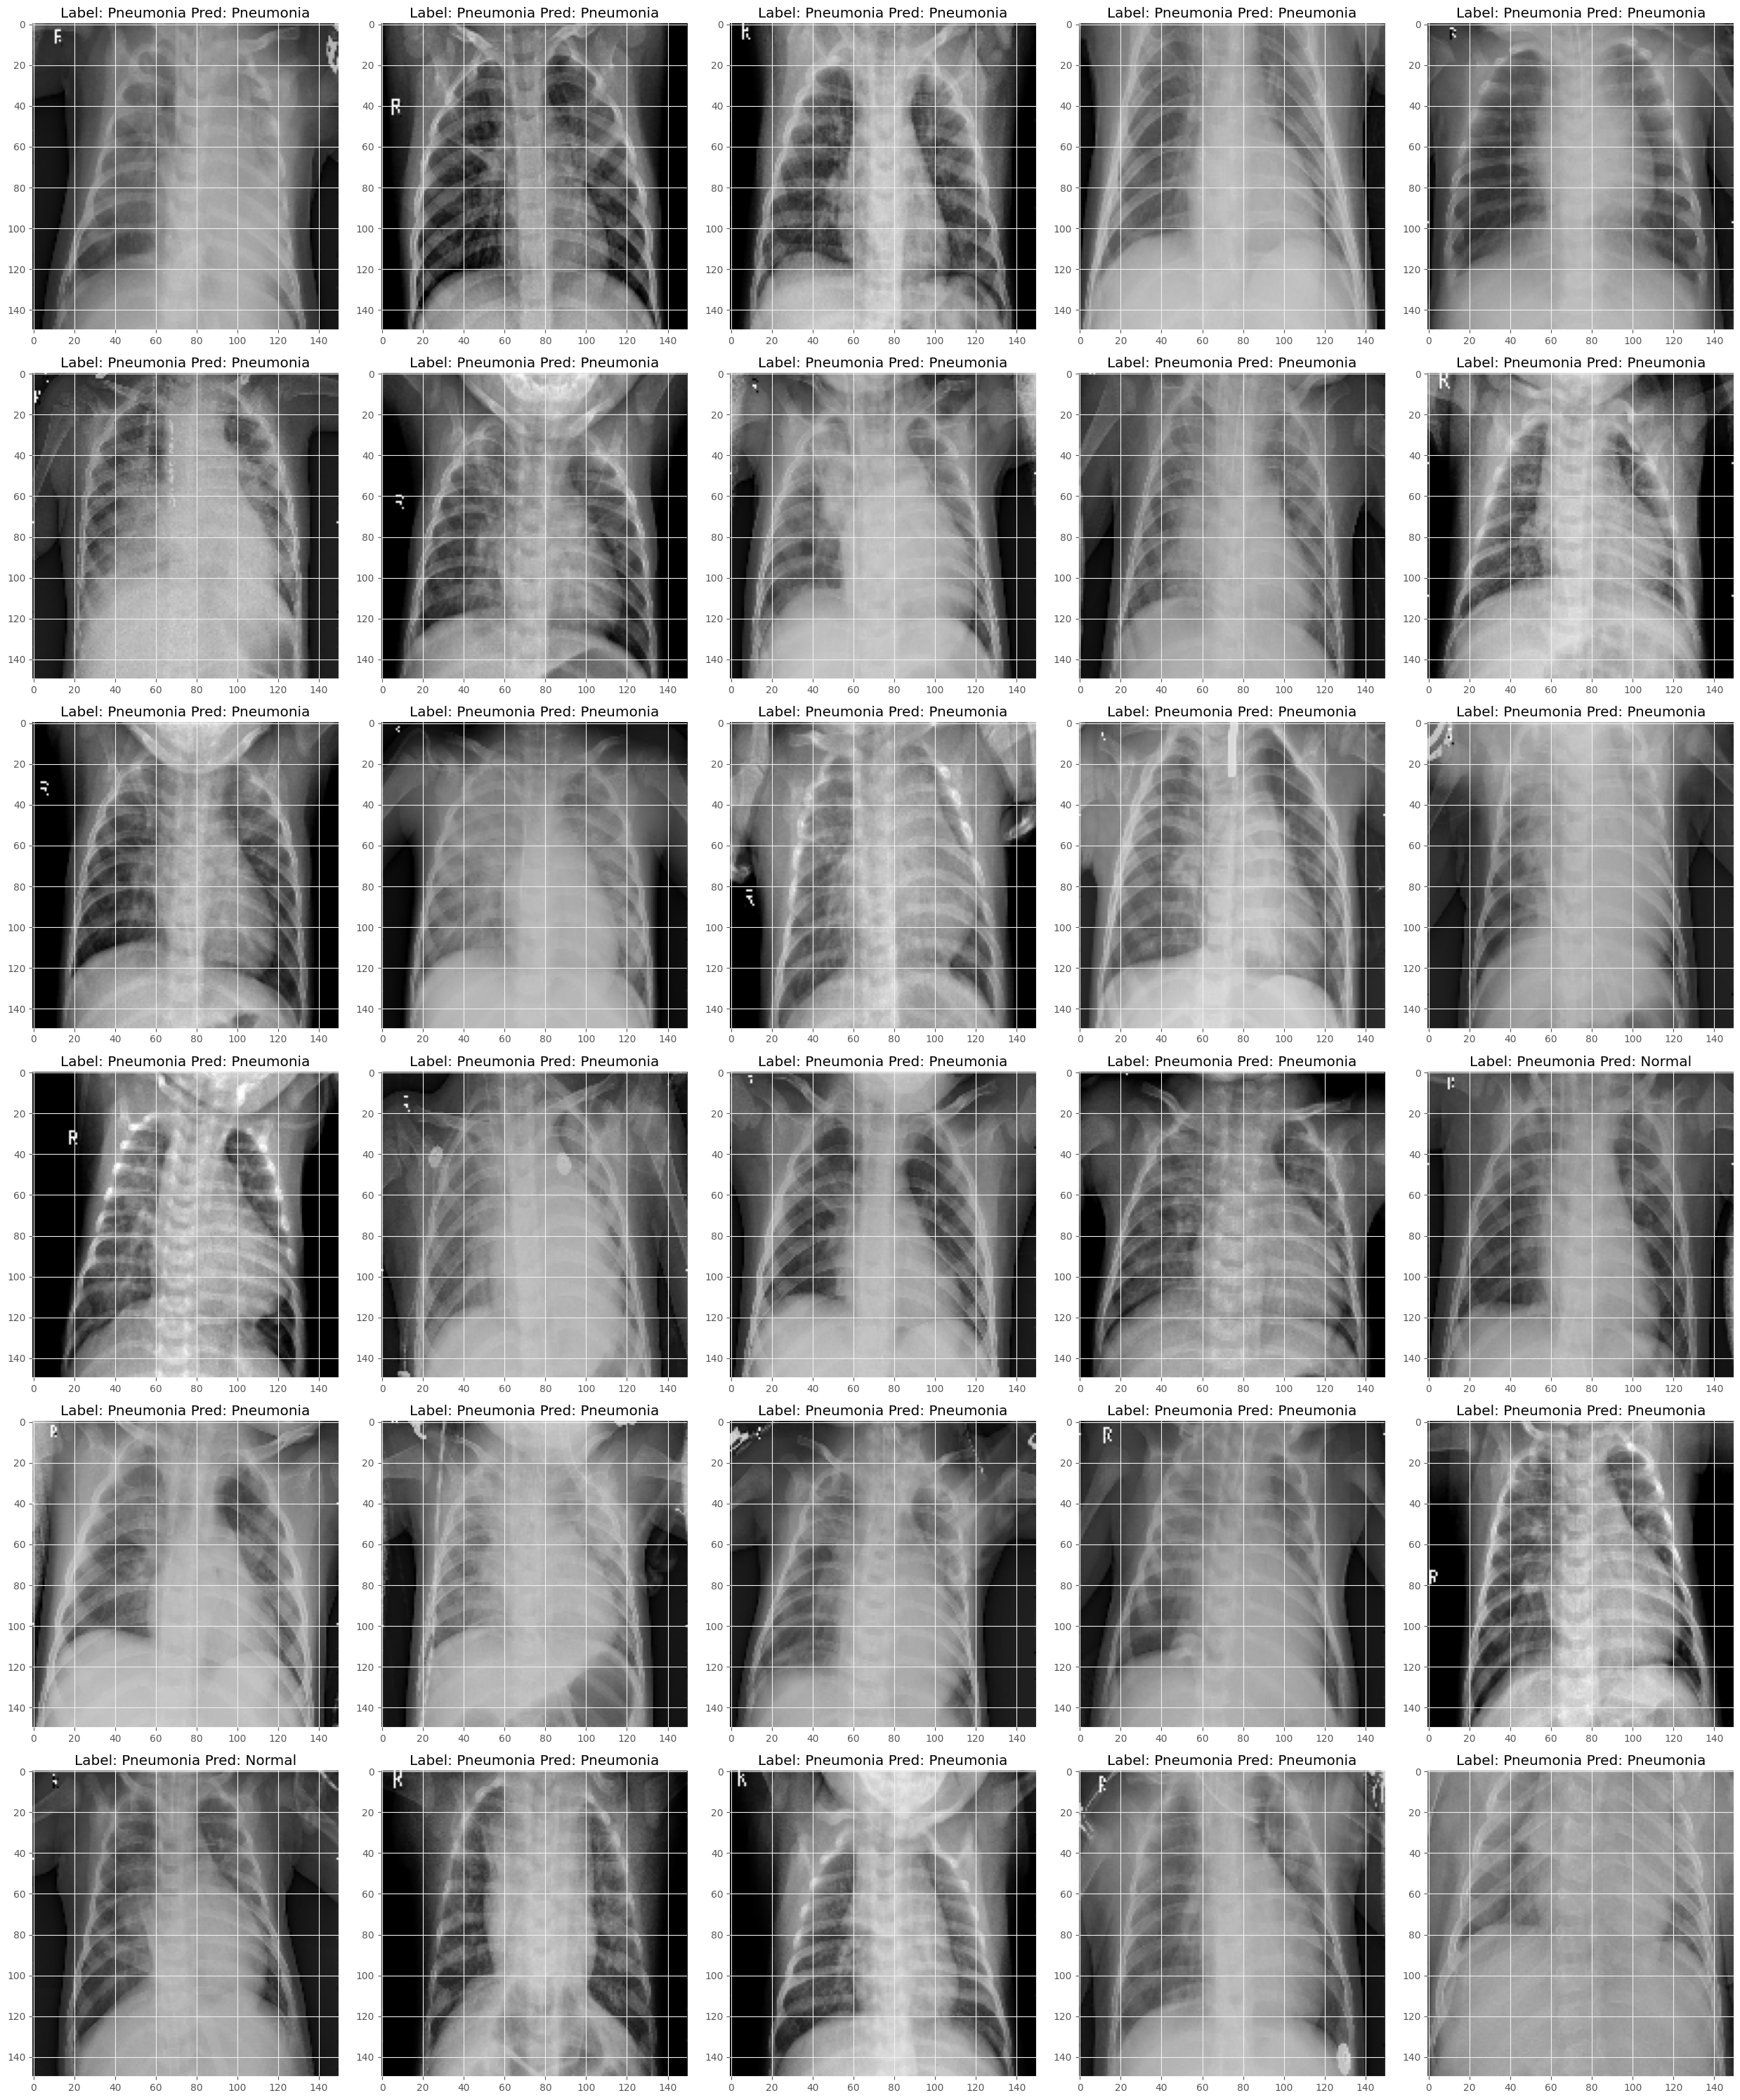

In [155]:
sample_images, labels = next(test_data_gen)
predictions = model4.predict(sample_images)

plotImages(visual_sample, labels, predictions, 6, 5)

O experimento 5.4 com data augmentation usando zoom teve o melhor desempenho. Para futuros projetos podemos tentar outras combinações de data augmentation usando diferentes valores.